In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import json
import os
import requests
import sys
import warnings
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import ShuffleSplit
from albumentations import (
    Compose, 
    ShiftScaleRotate,
)
from wandb.keras import WandbCallback

sys.path.append("..")
from utils.cam_utils import (
    get_img_arr,
    make_gradcam_heatmap,
    make_gradcam_img,
    view_img,
)
from utils.common import get_elapsed_time
from utils.data_utils import (
    load_tfrecord_dataset,
    mixup_dataset,
)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
config = configparser.ConfigParser()
_ = config.read(os.path.join("..", "conf", "config.ini"))

use_pseudo_label = False
proc_data_path = os.path.join("..", "proc_data")

project_name = config["project"]["project_name"]
run_name = config["project"]["run_name"]
raw_data_path = config["project"]["raw_data_path"]
raw_data_path = (
    os.path.join(raw_data_path, "pseudo_label") if use_pseudo_label else raw_data_path
)

fc_size = eval(config["model"]["fc_size"])
img_size = eval(config["model"]["img_size"])
n_epochs = eval(config["model"]["n_epochs"])
batch_size = eval(config["model"]["batch_size"])
initial_learning_rate = eval(config["model"]["initial_learning_rate"])
first_decay_steps = eval(config["model"]["first_decay_steps"])
use_adamw = eval(config["model"]["use_adamw"])
use_swa = eval(config["model"]["use_swa"])
use_mixup = eval(config["model"]["use_mixup"])
label_smoothing = eval(config["model"]["label_smoothing"])

label_names = {
    "c0": "safe driving",
    "c1": "texting - right",
    "c2": "talking on the phone - right",
    "c3": "texting - left",
    "c4": "talking on the phone - left",
    "c5": "operating the radio",
    "c6": "drinking",
    "c7": "reaching behind",
    "c8": "hair and makeup",
    "c9": "talking to passenger",
}

n_classes = len(label_names)

os.makedirs(proc_data_path, exist_ok=True)

In [4]:
run = wandb.init(project=project_name, reinit=False)

if len(run_name) > 0:
    wandb.run.name = run_name
    wandb.run.save()
    
wandb.config.update(
    {
        "fc_size": fc_size,
        "img_size": img_size,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "initial_learning_rate": initial_learning_rate,
        "first_decay_steps": first_decay_steps,
        "use_adamw": use_adamw,
        "use_swa": use_swa,
        "use_mixup": use_mixup,
        "label_smoothing": label_smoothing,
        "use_pseudo_label": use_pseudo_label,
    }
)

wandb: Currently logged in as: ... (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## An Input Data Pipeline Configuration with *Dataset* API

In [5]:
train_raw_data_path = os.path.join(raw_data_path, "imgs", "train")
test_raw_data_path = os.path.join(raw_data_path, "imgs", "test")

n_train_examples = len(
    tf.io.gfile.glob(os.path.join(train_raw_data_path, "*", "*.jpg"))
)

train_tfrec_paths = tf.io.gfile.glob(
    os.path.join(raw_data_path, "tfrec", "train", "*.tfrec")
)
test_img_paths = tf.io.gfile.glob(os.path.join(test_raw_data_path, "*.jpg"))

train_transforms = Compose(
    [
        ShiftScaleRotate(
            rotate_limit=(-20, 20),
            scale_limit=(0.0, 0.2),
            shift_limit_x=(-0.0625, 0.0625),
            shift_limit_y=(-0.046875, 0.046875),
            p=1.0,
        ),
    ]
)
valid_transforms = train_transforms

## Building and Compiling a Model

In [6]:
def get_model(
    img_size,
    fc_size,
    n_classes,
    initial_learning_rate,
    first_decay_steps,
    use_adamw,
    use_swa,
    label_smoothing,
    verbose=False,
):
    eff_net = tf.keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3)
    )
    eff_net.trainable = False
    
    x = tf.keras.layers.GlobalAveragePooling2D()(eff_net.output)
    x = tf.keras.layers.Dense(fc_size, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(fc_size, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    model = tf.keras.Model(eff_net.input, output)
    
    if verbose:
        print(model.summary())

    # For tensorflow 2.5 or later, use tf.keras.optimizers.schedules.CosineDecayRestarts.
    lr_decayed_fn = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate, first_decay_steps
    )
    optimizer = (
        tfa.optimizers.AdamW(lr_decayed_fn)
        if use_adamw
        else tfa.optimizers.RectifiedAdam(lr_decayed_fn)
    )
    if use_swa:
        optimizer = tfa.optimizers.SWA(optimizer, start_averaging=0, average_period=10)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=["acc"],
    )

    return model

## Model Training

In [7]:
test_size = 0.25
train_steps_per_epoch = round(n_train_examples * (1.0 - test_size) / batch_size)
valid_steps_per_epoch = round(n_train_examples * test_size / batch_size)

rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
split = rs.split(range(len(train_tfrec_paths)))
train_index, valid_index = next(split)

model_path = os.path.join("..", "models")
serving_path = os.path.join("..", "models", "serving")
prediction_path = os.path.join("..", "predictions")
version = 1
os.makedirs(os.path.join(serving_path, str(version)), exist_ok=True)

In [8]:
with get_elapsed_time():
    one_train_dataset = load_tfrecord_dataset(
        np.array(train_tfrec_paths)[train_index],
        img_size,
        train_transforms,
        batch_size,
        n_classes=n_classes,
        normalize=False,
    )

    if use_mixup:
        oth_train_dataset = load_tfrecord_dataset(
            np.array(train_tfrec_paths)[train_index],
            img_size,
            train_transforms,
            batch_size,
            n_classes=n_classes,
            normalize=False,
        )
        zipped = tf.data.Dataset.zip((one_train_dataset, oth_train_dataset))
        train_dataset = zipped.map(
            lambda x, y: mixup_dataset(x, y, alpha=0.2),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    else:
        train_dataset = one_train_dataset

    valid_dataset = load_tfrecord_dataset(
        np.array(train_tfrec_paths)[valid_index],
        img_size,
        valid_transforms,
        batch_size,
        n_classes=n_classes,
        normalize=False,
    )

    suffix = "_to_serve"
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(model_path, f"model{suffix}.h5"),
            monitor="val_loss",
        ),
        WandbCallback(),
    ]

    model = get_model(
        img_size,
        fc_size,
        n_classes,
        initial_learning_rate,
        first_decay_steps,
        use_adamw,
        use_swa,
        label_smoothing,
    )

    model.fit(
        train_dataset,
        epochs=n_epochs,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=valid_dataset,
        validation_steps=valid_steps_per_epoch,
        callbacks=callbacks,
    )

    tf.keras.models.save_model(
        model,
        serving_path,
        overwrite=True,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
    )

print("The model training task has been successfully completed.")

Epoch 1/500
526/526 [==============================] - 628s 1s/step - loss: 1.8809 - acc: 0.3438 - val_loss: 0.4742 - val_acc: 0.8584
Epoch 2/500
526/526 [==============================] - 605s 1s/step - loss: 0.9742 - acc: 0.7463 - val_loss: 0.6687 - val_acc: 0.7771
Epoch 3/500
  6/526 [..............................] - ETA: 7:27 - loss: 1.2264 - acc: 0.6080

wandb: Network error (ReadTimeout), entering retry loop.


526/526 [==============================] - 613s 1s/step - loss: 1.1545 - acc: 0.6641 - val_loss: 0.3425 - val_acc: 0.9102
Epoch 4/500
526/526 [==============================] - 621s 1s/step - loss: 0.9035 - acc: 0.7666 - val_loss: 0.2435 - val_acc: 0.9268
Epoch 5/500
526/526 [==============================] - 628s 1s/step - loss: 0.7705 - acc: 0.8286 - val_loss: 0.1611 - val_acc: 0.9552
Epoch 6/500
526/526 [==============================] - 638s 1s/step - loss: 0.7179 - acc: 0.8522 - val_loss: 0.3463 - val_acc: 0.8984
Epoch 7/500
526/526 [==============================] - 643s 1s/step - loss: 1.0279 - acc: 0.7268 - val_loss: 0.3004 - val_acc: 0.9127
Epoch 8/500
526/526 [==============================] - 641s 1s/step - loss: 0.8885 - acc: 0.7705 - val_loss: 0.1949 - val_acc: 0.9466
Epoch 9/500
526/526 [==============================] - 629s 1s/step - loss: 0.7943 - acc: 0.8169 - val_loss: 0.1605 - val_acc: 0.9571
Epoch 10/500
526/526 [==============================] - 647s 1s/step - los

## Model Explainability with Guided Grad-CAM

In [9]:
n_samples = 20
sampled_img_paths = np.random.choice(test_img_paths, n_samples)
last_conv_layer_name = "top_conv"
gradcam_img_arrs, labels = [], []

for img_path in sampled_img_paths:
    img_arr = get_img_arr(img_path, (img_size, img_size))
    heatmap_arr, label = make_gradcam_heatmap(img_arr, model, last_conv_layer_name)
    gradcam_img_arr = make_gradcam_img(
        img_path,
        heatmap_arr,
        cam_path=os.path.join(proc_data_path, img_path.split(os.path.sep)[-1]),
    )
    gradcam_img_arrs.append(gradcam_img_arr / 255.0)
    labels.append(label.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

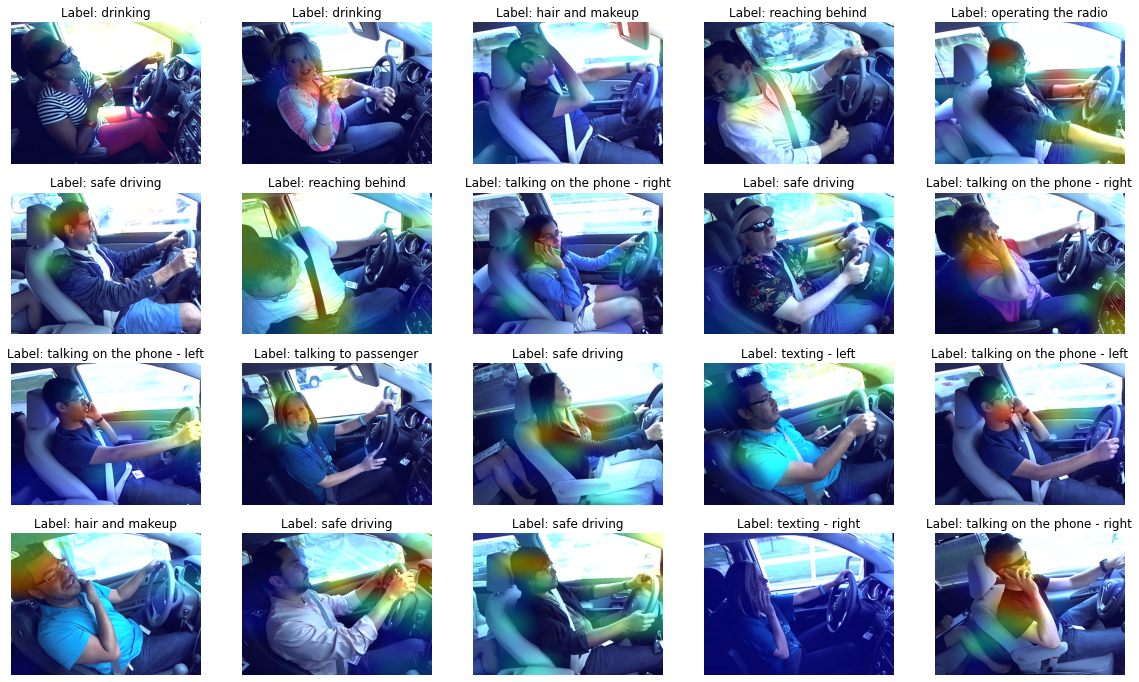

In [10]:
view_img(gradcam_img_arrs, labels, n_samples, label_names)

In [11]:
columns = ["image_id", "image", "label"]
data = []
for img_path, label in zip(
    sampled_img_paths,
    labels,
):
    data.append(
        [
            img_path.split(os.path.sep)[-1],
            wandb.Image(os.path.join(proc_data_path, img_path.split(os.path.sep)[-1])),
            label_names[f"c{str(label)}"],
        ]
    )

gradcam_img_table = wandb.Table(data=data, columns=columns)
wandb.log({"gradcam_img_table": gradcam_img_table})
run.finish()

acc,▁▆▄▆▇▇▅▆▇▇███▇▆▇▇▇
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▅▃▂▂▄▃▂▂▁▁▁▂▃▂▂▂
val_acc,▄▁▆▆▇▅▆▇▇████▆▇▇██
val_loss,▆█▄▃▂▄▃▂▂▁▁▁▁▃▂▂▂▂
acc,0.83341
best_epoch,12
best_val_loss,0.09691
epoch,17
loss,0.76573
val_acc,0.96411


## *TF Serving* Testing
* You need to download and run the docker image via `scripts/run.sh` file.

In [12]:
%%time
sampled_img_arrs = [
    get_img_arr(img_path, (480, 640))[0] for img_path in sampled_img_paths
]
sampled_img_arrs = np.stack(sampled_img_arrs, axis=0) / 255.0

data = json.dumps(
    {"signature_name": "serving_default", "instances": sampled_img_arrs.tolist()}
)
headers = {"content-type": "application/json"}
model_url = f"http://localhost:8501/v{str(version)}/models/state-farm-detection:predict"
json_response = requests.post(model_url, data=data, headers=headers)
predictions = json.loads(json_response.text)["predictions"]
predictions = np.array(predictions)

CPU times: user 16.9 s, sys: 5.63 s, total: 22.6 s
Wall time: 45.9 s


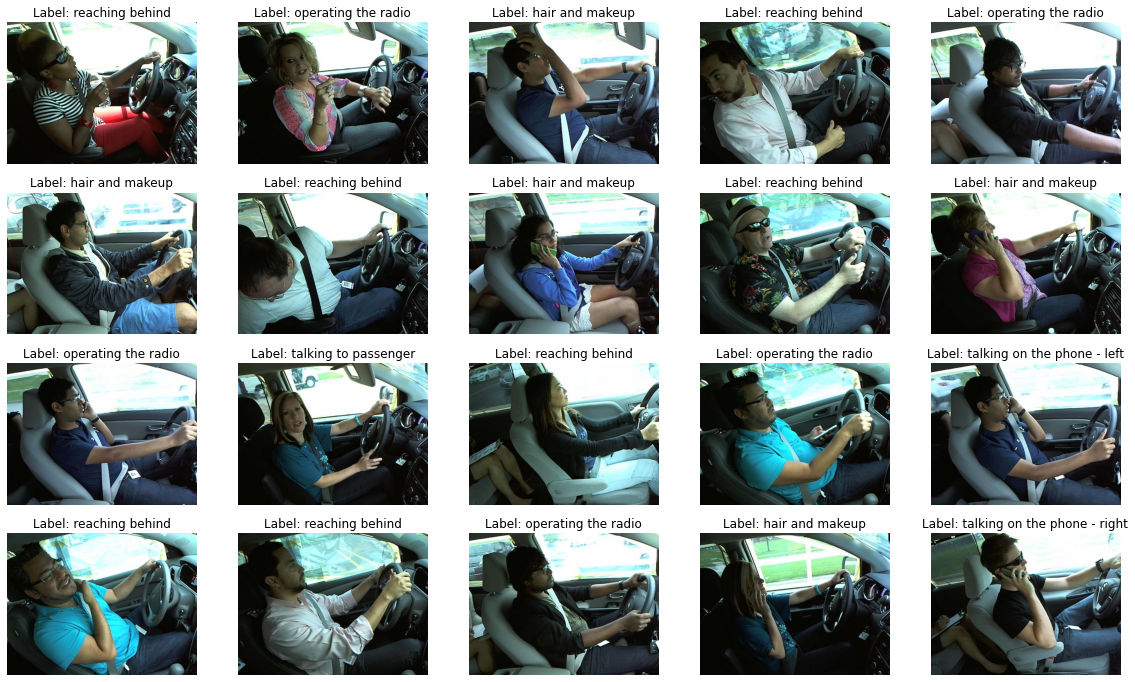

In [13]:
view_img(sampled_img_arrs, np.argmax(predictions, axis=1), n_samples, label_names)